
# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></div><div class="lev2 toc-item"><a href="#Visualise-the-Data" data-toc-modified-id="Visualise-the-Data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Visualise the Data</a></div><div class="lev2 toc-item"><a href="#Data-Normalization" data-toc-modified-id="Data-Normalization-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Normalization</a></div> 
<div class="lev1 toc-item"><a href="#Training-NN-Models" data-toc-modified-id="Training-NN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training NN Models</a></div><div class="lev2 toc-item"><a href="#Initial-ANN" data-toc-modified-id="Initial-ANN-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initial ANN</a></div>
<div class="lev2 toc-item"><a href="#Tuning-Learning-Rate" data-toc-modified-id="Tuning-Learning-Rate-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Tuning Learning Rate</a></div>
<div class="lev2 toc-item"><a href="#Tuning-Optimizer" data-toc-modified-id="Tuning-Optimizer-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Tuning Optimizer</a></div>
<div class="lev2 toc-item"><a href="#Tuning Batch_size" data-toc-modified-id="Tuning Batch_size-34"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Tuning Batch_size</a></div>
<div class="lev2 toc-item"><a href="#Droput-ANN" data-toc-modified-id="Dropout-ANN-35"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Dropout ANN</a></div>
<div class="lev2 toc-item"><a href="#Deep ANN" data-toc-modified-id="Deep-ANN-36"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Deep ANN</a></div>
<div class="lev2 toc-item"><a href="#Simple-CNN" data-toc-modified-id="Simple-CNN-37"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Simple CNN</a></div>
<div class="lev2 toc-item"><a href="#Dropout-CNN" data-toc-modified-id="Dropout-CNN-38"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Dropout CNN</a></div>
<div class="lev2 toc-item"><a href="#Deep-CNN-with-BatchNormalization" data-toc-modified-id="Deep-CNN-with-Normalization 39"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Deep CNN with BatchNormaization</a></div><div class="lev2 toc-item"><a href="#VGG-16" data-toc-modified-id="VGG-16-310"><span class="toc-item-num">3.10&nbsp;&nbsp;</span>VGG-16</a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
#from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
#from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add, Flatten
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

# Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [ ]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = (model.predict(X) > 0.5).astype("int32")
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_confusion_matrix_multiclass(model, X, y):
    y_pred = np.argmax(model.predict(X), axis=-1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
 

# Load Data

We will be using the Fashion-MNIST dataset, which is built into Keras. [Fashion_MNIST](https://keras.io/api/datasets/fashion_mnist/)

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


First of all we need to know what the size of the data we are dealing with is.
x_train, y_train, x_test and y_test are all numpy arrays, so we can just have a look at the shape attribute of each of them. [More info on Numpy](https://numpy.org/)

In [ ]:
print("Training data shape: ", x_train.shape)  
print("Test data shape", x_test.shape)        
print("Training response shape:, ", y_train.shape)
print("Testing response shape: ", y_test.shape)

image_size = (x_train.shape[1], x_train.shape[2])      # tuple (28, 28)

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)
Training response shape:,  (60000,)
Testing response shape:  (10000,)


# Visualize the Data

y = 2 Pullover


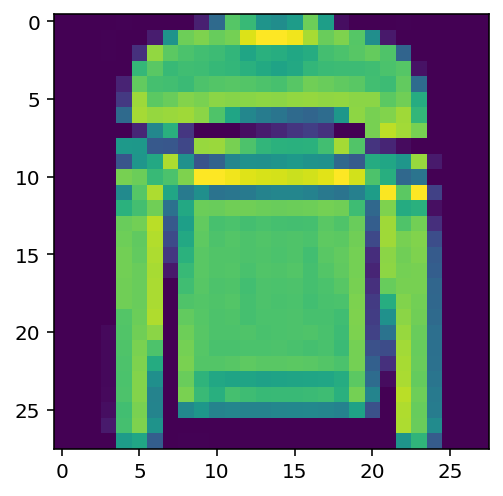

In [ ]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

# Image index, you can pick any number between 0 and 59,999
img_index = 5
# y_train contains the lables, ranging from 0 to 9
label_index = y_train[img_index]
# Print the label, for example 2 Pullover
print ("y = " + str(label_index) + " " +(fashion_mnist_labels[label_index]))
# # Show one of the images from the training dataset
plt.imshow(x_train[img_index])

# Data Normalization

This shows that we have 28 * 28 dimensional images with 60000 training images and 10000 testing images. \\
Next, in order to use a fully connected network to classify the images we need to convert these 28 * 28 images into vectors. \\
This can be done easily using the reshape function in numpy. [See this manual for more information of reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) \\
Additionally, as the inputs are images, we will rescale the vector values to be between 0 and 1 (rather than between 0 and 255). It will help our models to learn.

In [ ]:
# Flatten the images
image_vector_size = image_size[0] * image_size[1]                   # 28 * 28=784
x_train_reshape = x_train.reshape(x_train.shape[0], image_vector_size) /255.
x_test_reshape = x_test.reshape(x_test.shape[0], image_vector_size) /255.
print(x_train.shape)
print(x_train_reshape.shape)

(60000, 28, 28)
(60000, 784)


The final step in the data preparation is to convert the integer labels (target labels, what we want to predict) to one-hot encoded labels. \\
We convert labels "0", "1",...,"9" into vectors 1000000, 0100000,...,0000001. \\
Keras has a built in function that does this named to_categorical. \\
Be careful here, if you run this section of code more than once then you might one-hot-encode your one-hot-encoded labels!

In [ ]:
print("First 5 training labels: ", y_train[:5])    # [9,0,0,3,0]

# Convert to "one-hot" vectors using the to_categorical function
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [9 0 0 3 0]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(60000, 10)


## Training NN models
#1 Initial NN

Next we want to initialize our neural network model. \\
We start by defining the model from the Sequential() function and adding some Dense (fully-connected) layers. \\
Here we will be starting with a simple network with just a single hidden layer with 32 neurons. \\
Make sure you set the size of the output layer to be the number of classes that we are trying to predict! \\
We can have a look at out model using the model.summary() function.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


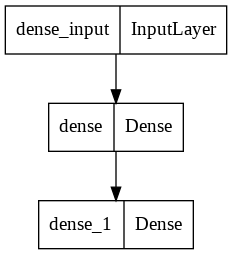

In [ ]:
#image_size = 784 # 28*28
#num_classes = 10 # ten unique digits
def build_basic_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))   #param=784*32 + 32(bias)
  model.add(Dense(units=num_classes, activation='softmax'))                            #param=32*10 + 10
  return model
model = build_basic_model()
model.summary()

plot_model(model)

Before training we must compile out model and select three important things:

1.   Paramaters of  optimisitation procedure to use. For now we will be using simple SGD - gradient descent, this optimizer is the first one to ever be used in practice and the most simple to understand. By default in Keras, SGD is a gradient descent  with a fixed learning rate. 
There are lots of other options for optimisation that we could look at though, for example using adaptive learning rate RMSprop, Adam, Adadelta, etc

2.   What loss function to use. For classification this loss function is almost always 'categorical_crossentropy', but if we were doing regression then we would be using a different loss function. Which one?

3. Finally, a metric. Generally, for classification, we are looking at the accuracy of the model. However we could also look at things like top k accuracy.

Finally, we are able to train our model to do some classification. Here we must select how long we wish to train for (epochs) and the mini-batch size. 

Epoch 1/50
422/422 [==============================] - 1s 2ms/step - loss: 2.0423 - accuracy: 0.4007 - val_loss: 1.7585 - val_accuracy: 0.6105
Epoch 2/50
422/422 [==============================] - 1s 1ms/step - loss: 1.5794 - accuracy: 0.6416 - val_loss: 1.4194 - val_accuracy: 0.6602
Epoch 3/50
422/422 [==============================] - 1s 1ms/step - loss: 1.3146 - accuracy: 0.6750 - val_loss: 1.2133 - val_accuracy: 0.6982
Epoch 4/50
422/422 [==============================] - 1s 1ms/step - loss: 1.1494 - accuracy: 0.6977 - val_loss: 1.0786 - val_accuracy: 0.7095
Epoch 5/50
422/422 [==============================] - 1s 1ms/step - loss: 1.0383 - accuracy: 0.7084 - val_loss: 0.9855 - val_accuracy: 0.7183
Epoch 6/50
422/422 [==============================] - 1s 1ms/step - loss: 0.9587 - accuracy: 0.7189 - val_loss: 0.9161 - val_accuracy: 0.7305
Epoch 7/50
422/422 [==============================] - 1s 1ms/step - loss: 0.8987 - accuracy: 0.7294 - val_loss: 0.8636 - val_accuracy: 0.7312
Epoch 

<Figure size 576x432 with 0 Axes>

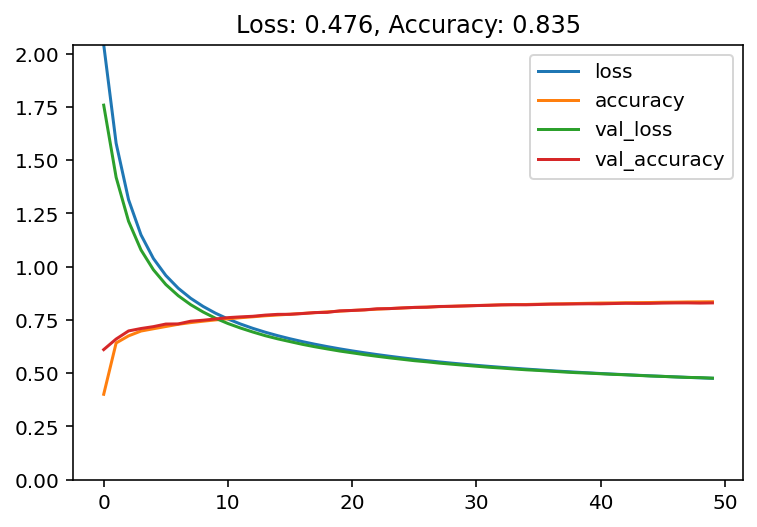

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_reshape, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)    
loss, accuracy  = model.evaluate(x_test_reshape, y_test, verbose=False)
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

#2 Tuning Learning Rate
Let's use SGD optimizer to tune learning rate.

In [ ]:
! pip install optuna
import optuna
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def objective(trial):
    model = build_basic_model()
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(tf.keras.optimizers.SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train_reshape, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc              

study = optuna.create_study(direction='maximize')   
study.optimize(objective, n_trials=10)  

[I 2022-06-04 02:43:31,221] A new study created in memory with name: no-name-aabe656e-b500-4fb4-8b76-4929cc8ec3f5


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.5289 - accuracy: 0.1006 - val_loss: 2.5359 - val_accuracy: 0.0915
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.5211 - accuracy: 0.1007 - val_loss: 2.5281 - val_accuracy: 0.0915
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.5135 - accuracy: 0.1007 - val_loss: 2.5205 - val_accuracy: 0.0913
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.5061 - accuracy: 0.1008 - val_loss: 2.5130 - val_accuracy: 0.0915
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.4989 - accuracy: 0.1008 - val_loss: 2.5057 - val_accuracy: 0.0917


[I 2022-06-04 02:43:41,949] Trial 0 finished with value: 0.09166666865348816 and parameters: {'lr': 1.6270118219258857e-05}. Best is trial 0 with value: 0.09166666865348816.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.3353 - accuracy: 0.0977 - val_loss: 2.3351 - val_accuracy: 0.0972
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3272 - accuracy: 0.0977 - val_loss: 2.3269 - val_accuracy: 0.0973
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3194 - accuracy: 0.0979 - val_loss: 2.3191 - val_accuracy: 0.0962
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3119 - accuracy: 0.0983 - val_loss: 2.3115 - val_accuracy: 0.0972
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3046 - accuracy: 0.0990 - val_loss: 2.3041 - val_accuracy: 0.0990


[I 2022-06-04 02:43:53,258] Trial 1 finished with value: 0.0989999994635582 and parameters: {'lr': 4.617218128802435e-05}. Best is trial 1 with value: 0.0989999994635582.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.2365 - accuracy: 0.1837 - val_loss: 2.1107 - val_accuracy: 0.3388
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.0187 - accuracy: 0.4389 - val_loss: 1.9309 - val_accuracy: 0.4957
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.8551 - accuracy: 0.5271 - val_loss: 1.7809 - val_accuracy: 0.5555
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 1.7174 - accuracy: 0.5633 - val_loss: 1.6531 - val_accuracy: 0.5867
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.6003 - accuracy: 0.5901 - val_loss: 1.5439 - val_accuracy: 0.6085


[I 2022-06-04 02:44:03,934] Trial 2 finished with value: 0.6085000038146973 and parameters: {'lr': 0.0031992657069745897}. Best is trial 2 with value: 0.6085000038146973.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.3729 - accuracy: 0.1006 - val_loss: 2.3649 - val_accuracy: 0.0942
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3384 - accuracy: 0.1006 - val_loss: 2.3318 - val_accuracy: 0.0942
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3096 - accuracy: 0.1007 - val_loss: 2.3038 - val_accuracy: 0.0942
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.2851 - accuracy: 0.1016 - val_loss: 2.2798 - val_accuracy: 0.0978
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.2639 - accuracy: 0.1071 - val_loss: 2.2587 - val_accuracy: 0.1053


[I 2022-06-04 02:44:10,543] Trial 3 finished with value: 0.10533333569765091 and parameters: {'lr': 0.00014980973350459435}. Best is trial 2 with value: 0.6085000038146973.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.1102 - accuracy: 0.3607 - val_loss: 1.9288 - val_accuracy: 0.5467
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 1.7924 - accuracy: 0.5839 - val_loss: 1.6652 - val_accuracy: 0.6290
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.5670 - accuracy: 0.6320 - val_loss: 1.4723 - val_accuracy: 0.6548
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 1.4020 - accuracy: 0.6573 - val_loss: 1.3284 - val_accuracy: 0.6810
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.2780 - accuracy: 0.6819 - val_loss: 1.2189 - val_accuracy: 0.7028


[I 2022-06-04 02:44:21,277] Trial 4 finished with value: 0.702833354473114 and parameters: {'lr': 0.005998396585538025}. Best is trial 4 with value: 0.702833354473114.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.3855 - accuracy: 0.1028 - val_loss: 2.3145 - val_accuracy: 0.1162
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.2787 - accuracy: 0.1384 - val_loss: 2.2274 - val_accuracy: 0.1783
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.1973 - accuracy: 0.2136 - val_loss: 2.1561 - val_accuracy: 0.2675
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.1291 - accuracy: 0.3085 - val_loss: 2.0943 - val_accuracy: 0.3573
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.0694 - accuracy: 0.3973 - val_loss: 2.0390 - val_accuracy: 0.4295


[I 2022-06-04 02:44:28,015] Trial 5 finished with value: 0.429500013589859 and parameters: {'lr': 0.0008027173259124184}. Best is trial 4 with value: 0.702833354473114.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.5474 - accuracy: 0.0989 - val_loss: 2.4569 - val_accuracy: 0.1097
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.4070 - accuracy: 0.1189 - val_loss: 2.3523 - val_accuracy: 0.1282
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3201 - accuracy: 0.1440 - val_loss: 2.2815 - val_accuracy: 0.1533
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.2576 - accuracy: 0.1694 - val_loss: 2.2272 - val_accuracy: 0.1753
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.2075 - accuracy: 0.1982 - val_loss: 2.1819 - val_accuracy: 0.2135


[I 2022-06-04 02:44:38,709] Trial 6 finished with value: 0.2134999930858612 and parameters: {'lr': 0.0004985938103052968}. Best is trial 4 with value: 0.702833354473114.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.2972 - accuracy: 0.1786 - val_loss: 2.1978 - val_accuracy: 0.2872
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 2.1452 - accuracy: 0.3374 - val_loss: 2.0801 - val_accuracy: 0.4037
Epoch 3/5
422/422 [==============================] - 1s 4ms/step - loss: 2.0371 - accuracy: 0.4405 - val_loss: 1.9826 - val_accuracy: 0.5038
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 1.9439 - accuracy: 0.5441 - val_loss: 1.8949 - val_accuracy: 0.5890
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.8598 - accuracy: 0.6011 - val_loss: 1.8150 - val_accuracy: 0.6217


[I 2022-06-04 02:44:49,424] Trial 7 finished with value: 0.621666669845581 and parameters: {'lr': 0.0016746926865784037}. Best is trial 4 with value: 0.702833354473114.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 1.7251 - accuracy: 0.5529 - val_loss: 1.3427 - val_accuracy: 0.6790
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 1.1719 - accuracy: 0.6986 - val_loss: 1.0262 - val_accuracy: 0.7237
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.9560 - accuracy: 0.7241 - val_loss: 0.8777 - val_accuracy: 0.7447
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.8424 - accuracy: 0.7444 - val_loss: 0.7899 - val_accuracy: 0.7565
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.7712 - accuracy: 0.7569 - val_loss: 0.7330 - val_accuracy: 0.7638


[I 2022-06-04 02:44:56,011] Trial 8 finished with value: 0.7638333439826965 and parameters: {'lr': 0.021862326714304037}. Best is trial 8 with value: 0.7638333439826965.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 2.4892 - accuracy: 0.1017 - val_loss: 2.4589 - val_accuracy: 0.0952
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.4234 - accuracy: 0.1121 - val_loss: 2.4006 - val_accuracy: 0.1152
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3731 - accuracy: 0.1333 - val_loss: 2.3553 - val_accuracy: 0.1358
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3334 - accuracy: 0.1498 - val_loss: 2.3191 - val_accuracy: 0.1500
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3012 - accuracy: 0.1588 - val_loss: 2.2893 - val_accuracy: 0.1582


[I 2022-06-04 02:45:06,694] Trial 9 finished with value: 0.15816666185855865 and parameters: {'lr': 0.00015389063650876765}. Best is trial 8 with value: 0.7638333439826965.


Let's see how our validation accuracy (Y axis) changed during 10 trials.

In [ ]:
plot_optimization_history(study)

Let's see what was the best value (gives best validation accuracy) of learning rate which Optuna found. Is it different from 0.01 (the default value of the Keras SGD optimiser) ?

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.7638333439826965
  Params: 
    lr: 0.021862326714304037



Finally, let's use use this new learning rate, train our model and evaluate perfomance on the test set. Did we get improved result?

Test loss: 0.439
Test accuracy: 0.857


<Figure size 576x432 with 0 Axes>

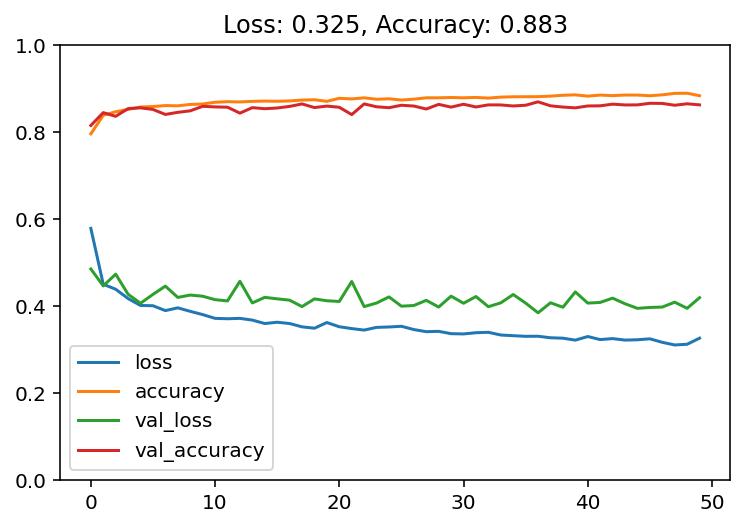

In [ ]:
model = build_basic_model()

best_lr=study.best_params['lr']
model.compile(tf.keras.optimizers.SGD(lr=best_lr), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_reshape, y_train, batch_size=128, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test_reshape, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

By changing the learning rate, the performance improves from model1 inital ANN 0.82 to 0.857. That's good.  
Let's tuning optimizers, see if we could further imrpove the performance. 

# 3 Tuning Optimizer

In [ ]:
def objective(trial):
    model = build_basic_model()
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'Adam', 'nadam', 'rmsprop', 'adadelta']) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train_reshape, y_train, batch_size=128, epochs=5, verbose=True, validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc              

study = optuna.create_study(direction='maximize')   
study.optimize(objective, n_trials=10)  

[I 2022-06-04 07:41:42,317] A new study created in memory with name: no-name-4a955349-6ead-4a49-a05c-ecafb2b6d700


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.8720 - accuracy: 0.7608 - val_loss: 0.5679 - val_accuracy: 0.8098
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5044 - accuracy: 0.8301 - val_loss: 0.4614 - val_accuracy: 0.8387
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4423 - accuracy: 0.8458 - val_loss: 0.4276 - val_accuracy: 0.8453
Epoch 4/5
422/422 [==============================] - 1s 4ms/step - loss: 0.4113 - accuracy: 0.8552 - val_loss: 0.4057 - val_accuracy: 0.8503
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.3918 - accuracy: 0.8616 - val_loss: 0.3905 - val_accuracy: 0.8580


[I 2022-06-04 07:41:53,333] Trial 0 finished with value: 0.8579999804496765 and parameters: {'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.9981 - accuracy: 0.7125 - val_loss: 0.6399 - val_accuracy: 0.7995
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5635 - accuracy: 0.8179 - val_loss: 0.5016 - val_accuracy: 0.8303
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4738 - accuracy: 0.8397 - val_loss: 0.4484 - val_accuracy: 0.8437
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4320 - accuracy: 0.8515 - val_loss: 0.4256 - val_accuracy: 0.8488
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4052 - accuracy: 0.8594 - val_loss: 0.4052 - val_accuracy: 0.8548


[I 2022-06-04 07:42:04,175] Trial 1 finished with value: 0.8548333048820496 and parameters: {'optimizer': 'Adam'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.0368 - accuracy: 0.3945 - val_loss: 1.7792 - val_accuracy: 0.5898
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 1.6154 - accuracy: 0.6276 - val_loss: 1.4682 - val_accuracy: 0.6732
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 1.3639 - accuracy: 0.6822 - val_loss: 1.2626 - val_accuracy: 0.7015
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 1.1958 - accuracy: 0.7034 - val_loss: 1.1224 - val_accuracy: 0.7185
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 1.0784 - accuracy: 0.7169 - val_loss: 1.0219 - val_accuracy: 0.7343


[I 2022-06-04 07:42:14,971] Trial 2 finished with value: 0.734333336353302 and parameters: {'optimizer': 'sgd'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 3s 5ms/step - loss: 2.4367 - accuracy: 0.0995 - val_loss: 2.4159 - val_accuracy: 0.1050
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 2.3971 - accuracy: 0.0998 - val_loss: 2.3758 - val_accuracy: 0.1067
Epoch 3/5
422/422 [==============================] - 1s 4ms/step - loss: 2.3577 - accuracy: 0.1012 - val_loss: 2.3367 - val_accuracy: 0.1092
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3197 - accuracy: 0.1057 - val_loss: 2.2993 - val_accuracy: 0.1137
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2836 - accuracy: 0.1126 - val_loss: 2.2640 - val_accuracy: 0.1217


[I 2022-06-04 07:42:25,817] Trial 3 finished with value: 0.12166666984558105 and parameters: {'optimizer': 'adadelta'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 3s 5ms/step - loss: 0.9636 - accuracy: 0.7306 - val_loss: 0.6149 - val_accuracy: 0.8042
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5475 - accuracy: 0.8218 - val_loss: 0.4901 - val_accuracy: 0.8325
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4661 - accuracy: 0.8413 - val_loss: 0.4423 - val_accuracy: 0.8443
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4291 - accuracy: 0.8514 - val_loss: 0.4164 - val_accuracy: 0.8488
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4060 - accuracy: 0.8583 - val_loss: 0.4012 - val_accuracy: 0.8567


[I 2022-06-04 07:42:35,492] Trial 4 finished with value: 0.8566666841506958 and parameters: {'optimizer': 'Adam'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3958 - accuracy: 0.0861 - val_loss: 2.3722 - val_accuracy: 0.0900
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3508 - accuracy: 0.0897 - val_loss: 2.3272 - val_accuracy: 0.0953
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 2.3079 - accuracy: 0.0973 - val_loss: 2.2855 - val_accuracy: 0.1095
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2687 - accuracy: 0.1186 - val_loss: 2.2477 - val_accuracy: 0.1422
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2333 - accuracy: 0.1583 - val_loss: 2.2136 - val_accuracy: 0.1805


[I 2022-06-04 07:42:46,539] Trial 5 finished with value: 0.18050000071525574 and parameters: {'optimizer': 'adadelta'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.9718 - accuracy: 0.7213 - val_loss: 0.6183 - val_accuracy: 0.8075
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5455 - accuracy: 0.8245 - val_loss: 0.4867 - val_accuracy: 0.8348
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4617 - accuracy: 0.8433 - val_loss: 0.4432 - val_accuracy: 0.8457
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4236 - accuracy: 0.8541 - val_loss: 0.4134 - val_accuracy: 0.8505
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4010 - accuracy: 0.8596 - val_loss: 0.4002 - val_accuracy: 0.8553


[I 2022-06-04 07:42:57,550] Trial 6 finished with value: 0.8553333282470703 and parameters: {'optimizer': 'Adam'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.9797 - accuracy: 0.7152 - val_loss: 0.6376 - val_accuracy: 0.8042
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5559 - accuracy: 0.8219 - val_loss: 0.4954 - val_accuracy: 0.8310
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4674 - accuracy: 0.8424 - val_loss: 0.4494 - val_accuracy: 0.8382
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4268 - accuracy: 0.8523 - val_loss: 0.4209 - val_accuracy: 0.8493
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4030 - accuracy: 0.8595 - val_loss: 0.3983 - val_accuracy: 0.8557


[I 2022-06-04 07:43:08,635] Trial 7 finished with value: 0.8556666374206543 and parameters: {'optimizer': 'Adam'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 4ms/step - loss: 0.9884 - accuracy: 0.7250 - val_loss: 0.6324 - val_accuracy: 0.8047
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.5571 - accuracy: 0.8207 - val_loss: 0.4989 - val_accuracy: 0.8322
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4710 - accuracy: 0.8396 - val_loss: 0.4602 - val_accuracy: 0.8368
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4323 - accuracy: 0.8502 - val_loss: 0.4215 - val_accuracy: 0.8515
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 0.4078 - accuracy: 0.8568 - val_loss: 0.4061 - val_accuracy: 0.8533


[I 2022-06-04 07:43:18,033] Trial 8 finished with value: 0.8533333539962769 and parameters: {'optimizer': 'Adam'}. Best is trial 0 with value: 0.8579999804496765.


Epoch 1/5
422/422 [==============================] - 2s 5ms/step - loss: 2.5245 - accuracy: 0.0995 - val_loss: 2.4953 - val_accuracy: 0.1055
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 2.4684 - accuracy: 0.1000 - val_loss: 2.4366 - val_accuracy: 0.1065
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 2.4093 - accuracy: 0.1014 - val_loss: 2.3774 - val_accuracy: 0.1093
Epoch 4/5
422/422 [==============================] - 1s 4ms/step - loss: 2.3514 - accuracy: 0.1058 - val_loss: 2.3210 - val_accuracy: 0.1165
Epoch 5/5
422/422 [==============================] - 2s 4ms/step - loss: 2.2978 - accuracy: 0.1177 - val_loss: 2.2702 - val_accuracy: 0.1353


[I 2022-06-04 07:43:29,072] Trial 9 finished with value: 0.1353333294391632 and parameters: {'optimizer': 'adadelta'}. Best is trial 0 with value: 0.8579999804496765.


Let's see how our validation accuracy (Y axis) changed during 10 trials.

In [ ]:
plot_optimization_history(study)

Let's see what was the best value (gives best validation accuracy) of optimize which Optuna found. Is it different from the default of the Keras SGD optimiser?

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.8568333387374878
  Params: 
    optimizer: Adam


The best optimzer might be different for each run, but it is one of Adam, Nadam and RMSProp. These 3 optimizers are quite similar. \\
Finally, let's use this optimize, train our model and evaluate performances on the test dataset.

Epoch 1/50
422/422 [==============================] - 2s 3ms/step - loss: 0.9829 - accuracy: 0.7118 - val_loss: 0.6315 - val_accuracy: 0.7957
Epoch 2/50
422/422 [==============================] - 1s 3ms/step - loss: 0.5522 - accuracy: 0.8210 - val_loss: 0.4950 - val_accuracy: 0.8267
Epoch 3/50
422/422 [==============================] - 1s 3ms/step - loss: 0.4669 - accuracy: 0.8406 - val_loss: 0.4415 - val_accuracy: 0.8422
Epoch 4/50
422/422 [==============================] - 1s 3ms/step - loss: 0.4282 - accuracy: 0.8517 - val_loss: 0.4166 - val_accuracy: 0.8535
Epoch 5/50
422/422 [==============================] - 1s 3ms/step - loss: 0.4043 - accuracy: 0.8577 - val_loss: 0.3984 - val_accuracy: 0.8562
Epoch 6/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3868 - accuracy: 0.8639 - val_loss: 0.3859 - val_accuracy: 0.8605
Epoch 7/50
422/422 [==============================] - 1s 3ms/step - loss: 0.3744 - accuracy: 0.8683 - val_loss: 0.3787 - val_accuracy: 0.8633
Epoch 

<Figure size 576x432 with 0 Axes>

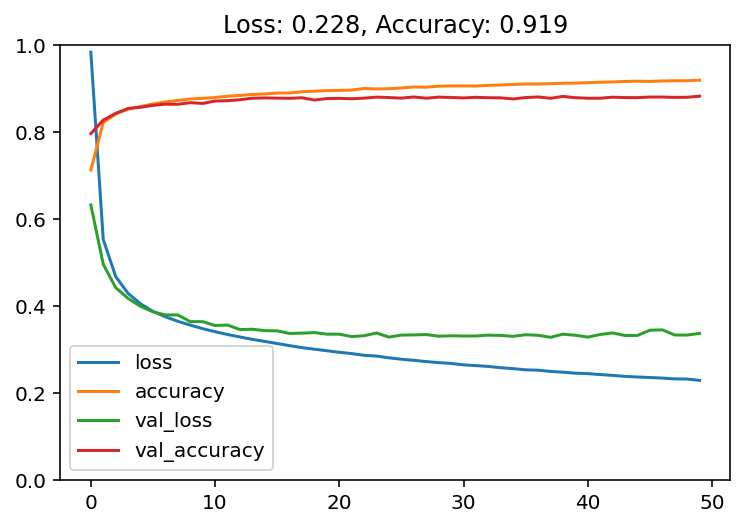

In [ ]:
model = build_basic_model()

best_optimizer=study.best_params['optimizer']
model.compile(best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_reshape, y_train, batch_size=128, epochs=50, verbose=True, validation_split=.1)     
loss, accuracy  = model.evaluate(x_test_reshape, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

By changing optimzer from SGD to Adam, the performance improves to 0.876, that's good. \\
But we start to face over-fitting issue. In the early stage of training all is going well, but the model is not generalizing well towards the end! This can be seen by the widening gap between the validation and training loss. \\
May we should reduce the batch_size, let's tune the batch_size. 

#4 Tuning Batch_size
Let's use Adam optimizer with its default learning rate 0.001, tune batch_size.

In [ ]:
def objective(trial):
    model = build_basic_model()
    size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 1024, 54000]) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])                      
    history = model.fit(x_train_reshape, y_train, batch_size=size, epochs=5, verbose=True, validation_split=.1)
    acc = history.history['val_accuracy'][-1]
    return acc             #we will use validation accuracy to compare perfomance of models trained with sample batch_sizes

Next we will sample 10 different batch_sizes and evaluate perfomance. It might take a bit of time, that's why we only use 5 epochs.

In [ ]:
study = optuna.create_study(direction='maximize')    # we would like to maximise the validation accuracy
study.optimize(objective, n_trials=10)               #use objective function defined above and sample 10 different batch_sizes

[I 2022-06-04 02:58:42,004] A new study created in memory with name: no-name-e3c2983c-2904-4fc6-b742-4fe6ff6e3b25


Epoch 1/5
211/211 [==============================] - 1s 5ms/step - loss: 1.1762 - accuracy: 0.6701 - val_loss: 0.7749 - val_accuracy: 0.7725
Epoch 2/5
211/211 [==============================] - 1s 4ms/step - loss: 0.6704 - accuracy: 0.7963 - val_loss: 0.5814 - val_accuracy: 0.8133
Epoch 3/5
211/211 [==============================] - 1s 4ms/step - loss: 0.5463 - accuracy: 0.8235 - val_loss: 0.5107 - val_accuracy: 0.8285
Epoch 4/5
211/211 [==============================] - 1s 4ms/step - loss: 0.4880 - accuracy: 0.8366 - val_loss: 0.4640 - val_accuracy: 0.8365
Epoch 5/5
211/211 [==============================] - 1s 4ms/step - loss: 0.4542 - accuracy: 0.8455 - val_loss: 0.4405 - val_accuracy: 0.8447


[I 2022-06-04 02:58:47,273] Trial 0 finished with value: 0.8446666598320007 and parameters: {'batch_size': 256}. Best is trial 0 with value: 0.8446666598320007.


Epoch 1/5
844/844 [==============================] - 2s 2ms/step - loss: 0.8241 - accuracy: 0.7547 - val_loss: 0.5508 - val_accuracy: 0.8070
Epoch 2/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4785 - accuracy: 0.8372 - val_loss: 0.4442 - val_accuracy: 0.8422
Epoch 3/5
844/844 [==============================] - 2s 2ms/step - loss: 0.4204 - accuracy: 0.8537 - val_loss: 0.4125 - val_accuracy: 0.8530
Epoch 4/5
844/844 [==============================] - 2s 2ms/step - loss: 0.3909 - accuracy: 0.8631 - val_loss: 0.3866 - val_accuracy: 0.8607
Epoch 5/5
844/844 [==============================] - 2s 2ms/step - loss: 0.3724 - accuracy: 0.8674 - val_loss: 0.3784 - val_accuracy: 0.8627


[I 2022-06-04 02:58:57,626] Trial 1 finished with value: 0.862666666507721 and parameters: {'batch_size': 64}. Best is trial 1 with value: 0.862666666507721.


Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 2.3769 - accuracy: 0.1942 - val_loss: 2.3075 - val_accuracy: 0.2513
Epoch 2/5
1/1 [==============================] - 0s 293ms/step - loss: 2.3128 - accuracy: 0.2419 - val_loss: 2.2531 - val_accuracy: 0.2795
Epoch 3/5
1/1 [==============================] - 0s 284ms/step - loss: 2.2587 - accuracy: 0.2706 - val_loss: 2.2079 - val_accuracy: 0.3140
Epoch 4/5
1/1 [==============================] - 0s 246ms/step - loss: 2.2137 - accuracy: 0.3042 - val_loss: 2.1700 - val_accuracy: 0.3507
Epoch 5/5
1/1 [==============================] - 0s 255ms/step - loss: 2.1757 - accuracy: 0.3428 - val_loss: 2.1368 - val_accuracy: 0.3687


[I 2022-06-04 02:59:00,832] Trial 2 finished with value: 0.3686666786670685 and parameters: {'batch_size': 54000}. Best is trial 1 with value: 0.862666666507721.


Epoch 1/5
1/1 [==============================] - 1s 912ms/step - loss: 2.4231 - accuracy: 0.1053 - val_loss: 2.3559 - val_accuracy: 0.1247
Epoch 2/5
1/1 [==============================] - 0s 275ms/step - loss: 2.3479 - accuracy: 0.1239 - val_loss: 2.2869 - val_accuracy: 0.1673
Epoch 3/5
1/1 [==============================] - 0s 429ms/step - loss: 2.2811 - accuracy: 0.1641 - val_loss: 2.2267 - val_accuracy: 0.2237
Epoch 4/5
1/1 [==============================] - 0s 263ms/step - loss: 2.2228 - accuracy: 0.2179 - val_loss: 2.1744 - val_accuracy: 0.2995
Epoch 5/5
1/1 [==============================] - 0s 246ms/step - loss: 2.1722 - accuracy: 0.2929 - val_loss: 2.1291 - val_accuracy: 0.3395


[I 2022-06-04 02:59:03,912] Trial 3 finished with value: 0.3395000100135803 and parameters: {'batch_size': 54000}. Best is trial 1 with value: 0.862666666507721.


Epoch 1/5
422/422 [==============================] - 3s 4ms/step - loss: 0.9686 - accuracy: 0.7244 - val_loss: 0.6260 - val_accuracy: 0.8033
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.5521 - accuracy: 0.8206 - val_loss: 0.4946 - val_accuracy: 0.8310
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4672 - accuracy: 0.8399 - val_loss: 0.4474 - val_accuracy: 0.8468
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.8511 - val_loss: 0.4179 - val_accuracy: 0.8482
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4033 - accuracy: 0.8585 - val_loss: 0.4014 - val_accuracy: 0.8568


[I 2022-06-04 02:59:11,851] Trial 4 finished with value: 0.8568333387374878 and parameters: {'batch_size': 128}. Best is trial 1 with value: 0.862666666507721.


Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.7175 - accuracy: 0.7747 - val_loss: 0.4763 - val_accuracy: 0.8323
Epoch 2/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4373 - accuracy: 0.8487 - val_loss: 0.4072 - val_accuracy: 0.8512
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3911 - accuracy: 0.8615 - val_loss: 0.3860 - val_accuracy: 0.8618
Epoch 4/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3662 - accuracy: 0.8697 - val_loss: 0.3655 - val_accuracy: 0.8648
Epoch 5/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3507 - accuracy: 0.8755 - val_loss: 0.3607 - val_accuracy: 0.8690


[I 2022-06-04 02:59:32,840] Trial 5 finished with value: 0.8690000176429749 and parameters: {'batch_size': 32}. Best is trial 5 with value: 0.8690000176429749.


Epoch 1/5
1/1 [==============================] - 1s 866ms/step - loss: 2.5862 - accuracy: 0.0914 - val_loss: 2.4874 - val_accuracy: 0.1405
Epoch 2/5
1/1 [==============================] - 0s 274ms/step - loss: 2.5046 - accuracy: 0.1311 - val_loss: 2.4165 - val_accuracy: 0.1775
Epoch 3/5
1/1 [==============================] - 0s 280ms/step - loss: 2.4323 - accuracy: 0.1669 - val_loss: 2.3548 - val_accuracy: 0.2000
Epoch 4/5
1/1 [==============================] - 0s 228ms/step - loss: 2.3692 - accuracy: 0.1894 - val_loss: 2.3012 - val_accuracy: 0.2157
Epoch 5/5
1/1 [==============================] - 0s 227ms/step - loss: 2.3142 - accuracy: 0.2036 - val_loss: 2.2542 - val_accuracy: 0.2257


[I 2022-06-04 02:59:35,897] Trial 6 finished with value: 0.22566667199134827 and parameters: {'batch_size': 54000}. Best is trial 5 with value: 0.8690000176429749.


Epoch 1/5
1/1 [==============================] - 1s 854ms/step - loss: 2.4996 - accuracy: 0.1065 - val_loss: 2.4089 - val_accuracy: 0.1258
Epoch 2/5
1/1 [==============================] - 0s 289ms/step - loss: 2.4237 - accuracy: 0.1159 - val_loss: 2.3487 - val_accuracy: 0.1263
Epoch 3/5
1/1 [==============================] - 0s 267ms/step - loss: 2.3624 - accuracy: 0.1165 - val_loss: 2.3002 - val_accuracy: 0.1392
Epoch 4/5
1/1 [==============================] - 0s 258ms/step - loss: 2.3127 - accuracy: 0.1324 - val_loss: 2.2602 - val_accuracy: 0.1667
Epoch 5/5
1/1 [==============================] - 0s 230ms/step - loss: 2.2716 - accuracy: 0.1563 - val_loss: 2.2263 - val_accuracy: 0.2258


[I 2022-06-04 02:59:38,949] Trial 7 finished with value: 0.22583332657814026 and parameters: {'batch_size': 54000}. Best is trial 5 with value: 0.8690000176429749.


Epoch 1/5
53/53 [==============================] - 1s 12ms/step - loss: 1.7454 - accuracy: 0.4631 - val_loss: 1.3754 - val_accuracy: 0.6553
Epoch 2/5
53/53 [==============================] - 0s 9ms/step - loss: 1.2217 - accuracy: 0.6850 - val_loss: 1.0788 - val_accuracy: 0.7253
Epoch 3/5
53/53 [==============================] - 0s 8ms/step - loss: 0.9974 - accuracy: 0.7324 - val_loss: 0.9067 - val_accuracy: 0.7570
Epoch 4/5
53/53 [==============================] - 0s 9ms/step - loss: 0.8550 - accuracy: 0.7555 - val_loss: 0.7910 - val_accuracy: 0.7690
Epoch 5/5
53/53 [==============================] - 0s 8ms/step - loss: 0.7576 - accuracy: 0.7741 - val_loss: 0.7108 - val_accuracy: 0.7868


[I 2022-06-04 02:59:41,977] Trial 8 finished with value: 0.7868333458900452 and parameters: {'batch_size': 1024}. Best is trial 5 with value: 0.8690000176429749.


Epoch 1/5
422/422 [==============================] - 2s 3ms/step - loss: 0.9879 - accuracy: 0.7178 - val_loss: 0.6375 - val_accuracy: 0.8007
Epoch 2/5
422/422 [==============================] - 1s 3ms/step - loss: 0.5590 - accuracy: 0.8177 - val_loss: 0.4944 - val_accuracy: 0.8322
Epoch 3/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4706 - accuracy: 0.8409 - val_loss: 0.4456 - val_accuracy: 0.8487
Epoch 4/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4288 - accuracy: 0.8516 - val_loss: 0.4227 - val_accuracy: 0.8497
Epoch 5/5
422/422 [==============================] - 1s 3ms/step - loss: 0.4048 - accuracy: 0.8584 - val_loss: 0.4117 - val_accuracy: 0.8498


[I 2022-06-04 02:59:52,704] Trial 9 finished with value: 0.8498333096504211 and parameters: {'batch_size': 128}. Best is trial 5 with value: 0.8690000176429749.


Let's see how our validation accuracy (Y axis) changed during 10 trials. 

In [ ]:
plot_optimization_history(study)

Let's see what was the best value (gives best validation accuracy) of batch_size which Optuna found. Is it less than 128?

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.8690000176429749
  Params: 
    batch_size: 32


Finally, let's use use this batch_size, train our model and evaluate perfomance on the test set. Did we get improved result?

Epoch 1/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6996 - accuracy: 0.7843 - val_loss: 0.4715 - val_accuracy: 0.8350
Epoch 2/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4401 - accuracy: 0.8466 - val_loss: 0.4107 - val_accuracy: 0.8547
Epoch 3/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3952 - accuracy: 0.8598 - val_loss: 0.3853 - val_accuracy: 0.8583
Epoch 4/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3714 - accuracy: 0.8677 - val_loss: 0.3665 - val_accuracy: 0.8673
Epoch 5/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3546 - accuracy: 0.8736 - val_loss: 0.3544 - val_accuracy: 0.8717
Epoch 6/50
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3410 - accuracy: 0.8785 - val_loss: 0.3516 - val_accuracy: 0.8728
Epoch 7/50
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3294 - accuracy: 0.8816 - val_loss: 0.3469 - val_accuracy:

<Figure size 576x432 with 0 Axes>

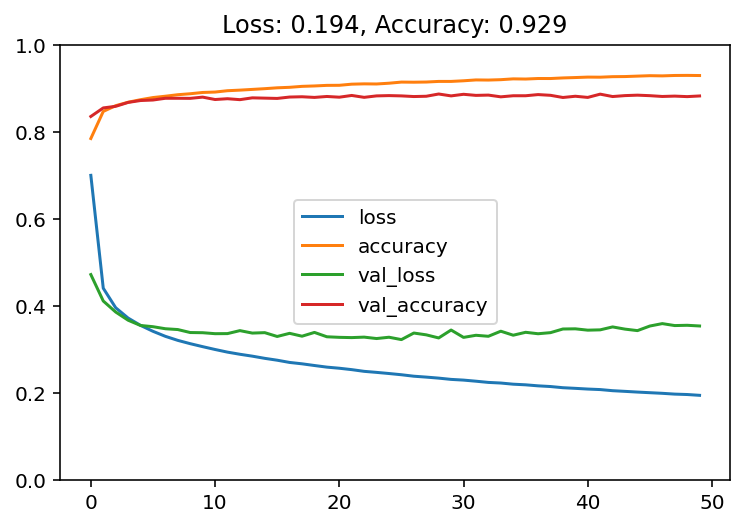

In [ ]:
model = build_basic_model()

best_size=study.best_params['batch_size']
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_reshape, y_train, batch_size=best_size, epochs=50, verbose=True, validation_split=.1)     
loss, accuracy  = model.evaluate(x_test_reshape, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Comparing to model1 initial ANN, the performance improves. The performance is quite similar to model3 tuning optimizers. \\
Tuning optimizer, learning rate and batch-size, the performance of initial ANN increases from 0.82 to around 0.87. \\
Decreasing the batch-size doesnot address the over-fitting issues, this can be seen by the widening gap between the validation and training loss and accuracy lines. How about we apply drop-out layer to address the over-fitting issue. 

#5 Dropout ANN

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


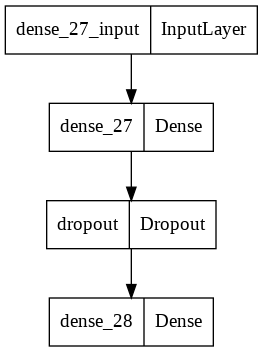

In [ ]:
def build_dropout_model():
  model = Sequential()

  # The input layer requires the special input_shape parameter which should match
  # the shape of our training data.
  model.add(Dense(units=32, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dropout(0.3))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model
  
model = build_dropout_model()
model.summary()

plot_model(model)

Test loss: 0.378
Test accuracy: 0.871


<Figure size 576x432 with 0 Axes>

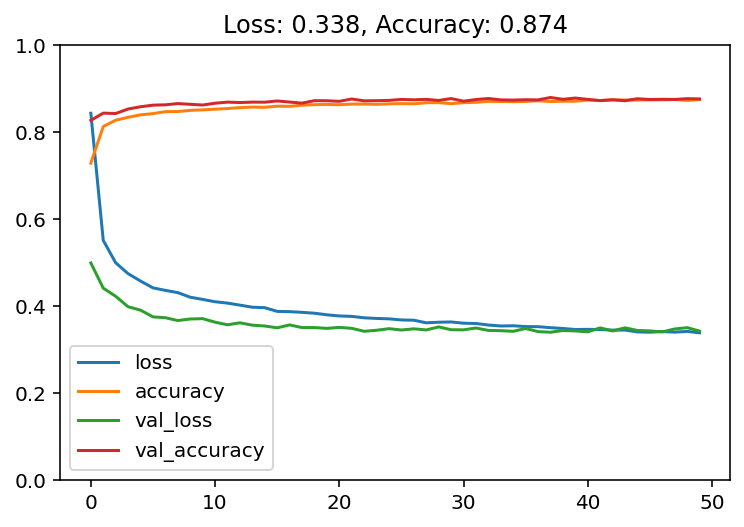

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_reshape, y_train, batch_size=best_size, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test_reshape, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Comparing to model1 inital ANN, model5 adding drop-out layer has the same parameters with model1 and it improves the performance . \\
Comparing to model2 and model3 and model4, the over-fitting issue has been addressed with similar performance, that's really good. \\
Let's see if we could further improve our performance with adding more layer, building a deep ANN.


# 6 Deep ANN

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 64)                50240     
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


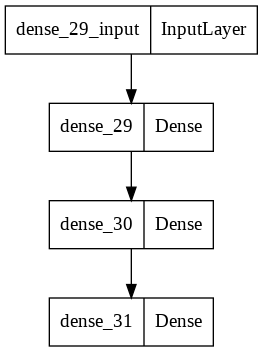

In [ ]:
def build_deeper_model():
  model = Sequential()
  model.add(Dense(units=64, activation='sigmoid', input_shape=(image_vector_size,)))
  model.add(Dense(units=32, activation='sigmoid'))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

model = build_deeper_model()
model.summary()

plot_model(model)  

Test loss: 0.441
Test accuracy: 0.878


<Figure size 576x432 with 0 Axes>

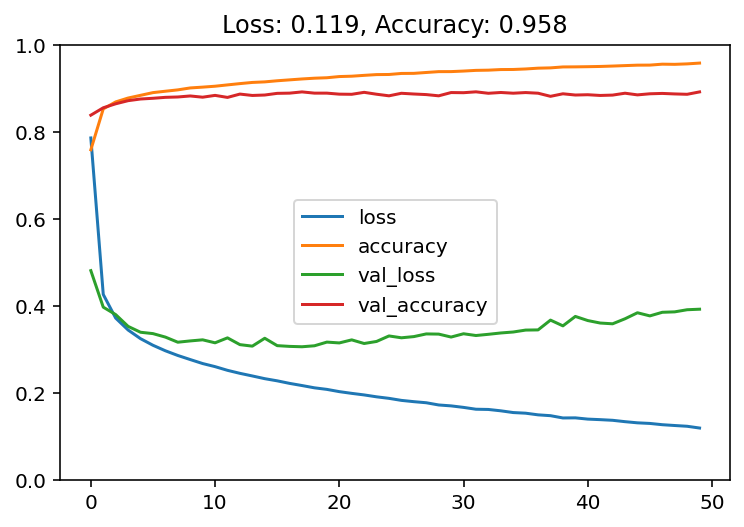

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_reshape, y_train, batch_size=best_size, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test_reshape, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Comparing model1 inital ANN and model5 dropout ANN, the performance of deep ANN improves to 0.878. But the paramters is nearly double of model5 which means it needs more time to train, and the over-fitting issue starts appear, this can be seen by the widening gap between the validation and training loss and accuracy lines. \\
We could further add dropout layer to address over-fitting issue, and add more layers of ANN and at the same time add dropout layer, see if the performance could be further improved. But that would keep increasing the number of parameters, more time needed to train. Let's stop here for now. \\
How about we try different architecture CNN ?

#7 Simple CNN
We start with 2 Convolutional layers + 2 MaxPooling layers + 2 Fully-Connected layers.

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_32 (Dense)            (None, 64)              

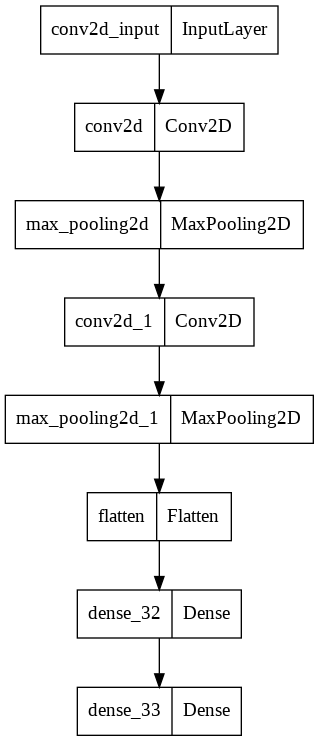

In [ ]:
def build_cnn1_model():
  model = Sequential()

  # Must define the input shape in the first layer of the neural network
  model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28,1))) 
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))

  return model

model = build_cnn1_model()
model.summary()

plot_model(model)

Test loss: 0.907
Test accuracy: 0.885


<Figure size 576x432 with 0 Axes>

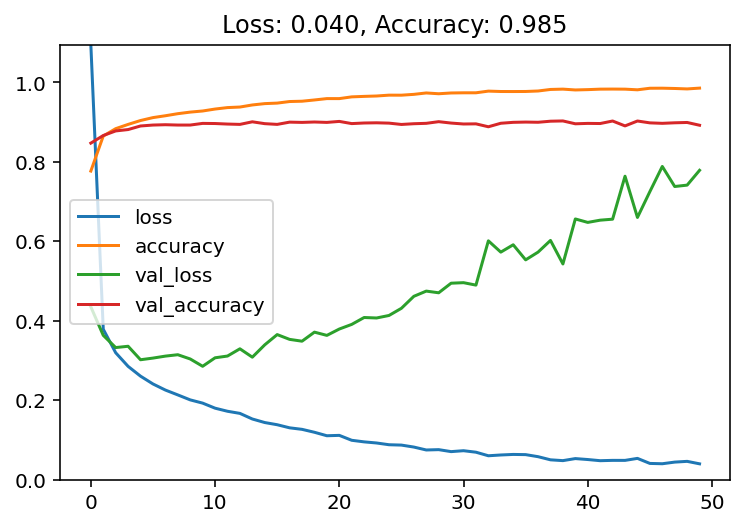

In [ ]:
model.compile(tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

The performance of model7 simple CNN is 0.885, best so far. It's notable model7 has similar number of parameters to model6 deep ANN. We can see, CNN is more powerful than ANN on this image classification task. \\
But the over-fitting issue is significantly, this can be seen by the widening gap between the validation and training loss and accuracy lines. Let's add dropout layers. 

#8 Dropout CNN
After some experiments, we have built below architecture of NN: 2 Convolutional layers + 2 MaxPooling layers + 3 Dropout layers + 2 Fully-Connected layers.


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 9, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 32)          18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 32)        

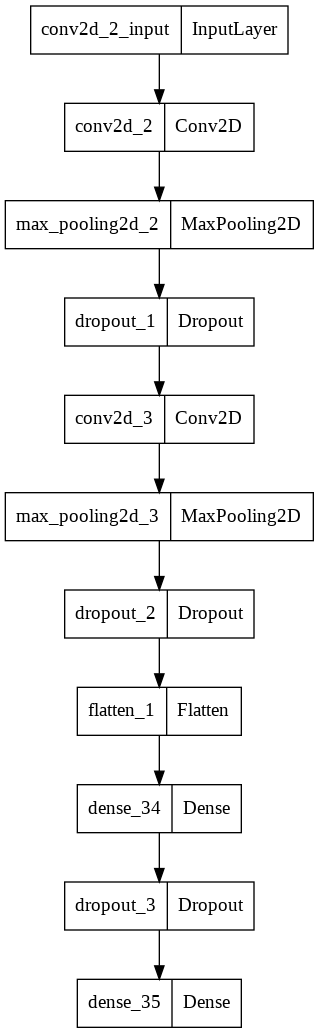

In [ ]:
def build_cnn2_model():
  model = Sequential()

  # Must define the input shape in the first layer of the neural network
  model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(28, 28,1))) 
  model.add(MaxPooling2D(pool_size=3))
  model.add(Dropout(0.3))

  model.add(Conv2D(32, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  return model

model = build_cnn2_model()
model.summary()

plot_model(model)

Test loss: 0.269
Test accuracy: 0.9


<Figure size 576x432 with 0 Axes>

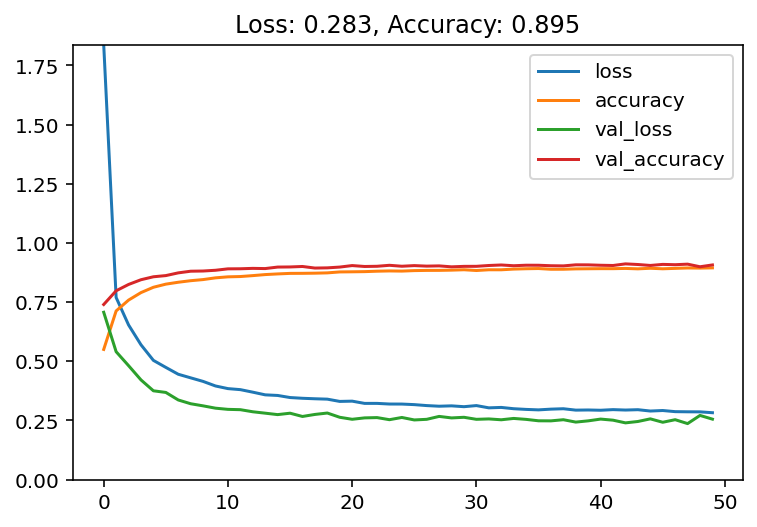

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

The performance reachs 0.9, and no over-fitting, best so far, that's pretty good. \\
Let's further experiment with CNN, see if we could further improve the performance.  

#9 Deep CNN with BatchNormalization
After various experiments, the below model provided the best performance with deep convolutional layers and apply Batch Normalization.

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout_5 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 24)        6936      
                                                     

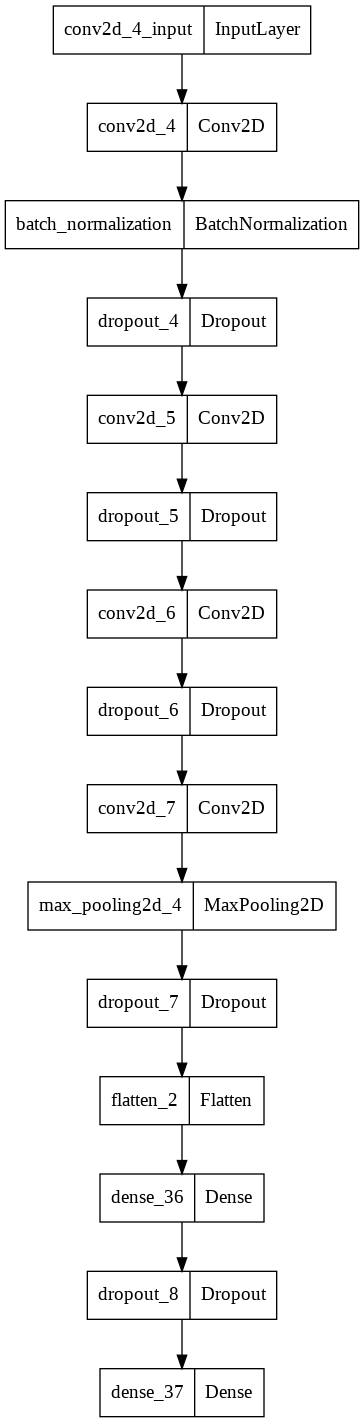

In [ ]:
def build_cnn3_model():
  model = Sequential()

  # Must define the input shape in the first layer of the neural network
  model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28,1))) 
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(32, 3, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(24, 3, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(64, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(num_classes, activation='softmax'))

  return model

model = build_cnn3_model()
model.summary()

plot_model(model)

2022-06-03 17:41:57.465681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-06-03 17:41:58.435038: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Test loss: 0.278
Test accuracy: 0.931


<Figure size 576x432 with 0 Axes>

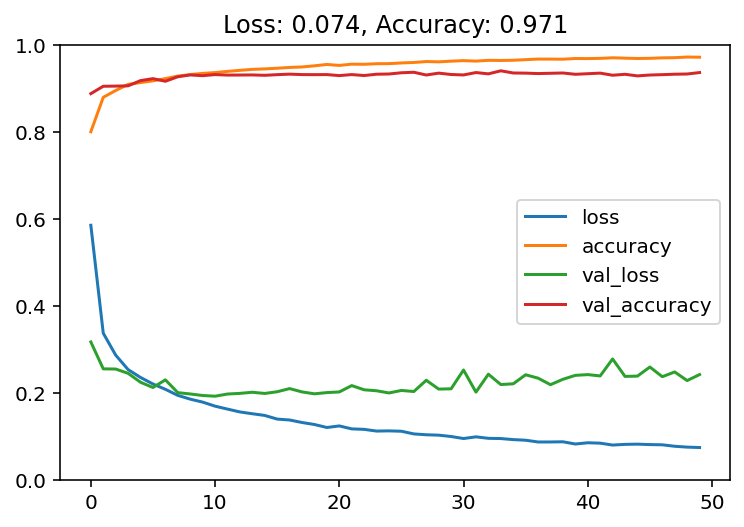

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

Wow, this model performances reaches 0.931, that's excellent !!! \\
However, a minor over-fitting issue might exist, there may still be slight imrpovements in validation loss beyond this point. 

#10 VGG-16
Lastly, let's experiment VGG-16.

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                 

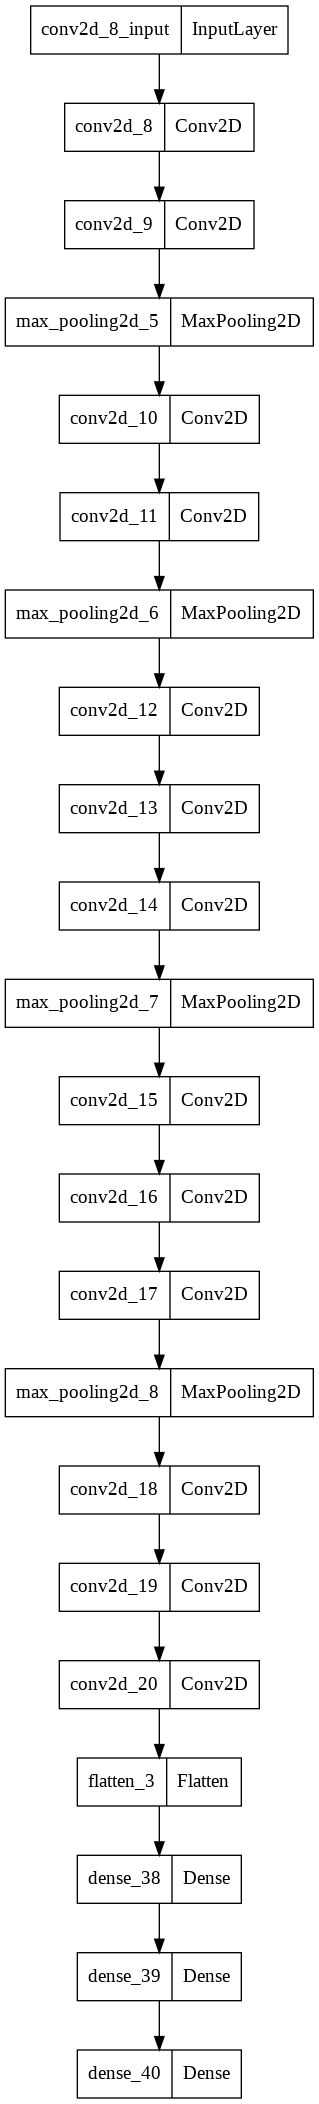

In [ ]:
def build_vgg_model():
  model = Sequential()

  # Must define the input shape in the first layer of the neural network
  model.add(Conv2D(64, 3, padding='same', activation='relu', input_shape=(28, 28,1))) 
  model.add(Conv2D(64, 3, padding='same', activation='relu')) 
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(Conv2D(128, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(Conv2D(256, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
  
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2))) 
  
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  model.add(Conv2D(512, 3, padding='same', activation='relu'))
  #model.add(MaxPooling2D(pool_size=2))
  
  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))

  return model

model = build_vgg_model()
model.summary()

plot_model(model)

Test loss: 0.445
Test accuracy: 0.921


<Figure size 576x432 with 0 Axes>

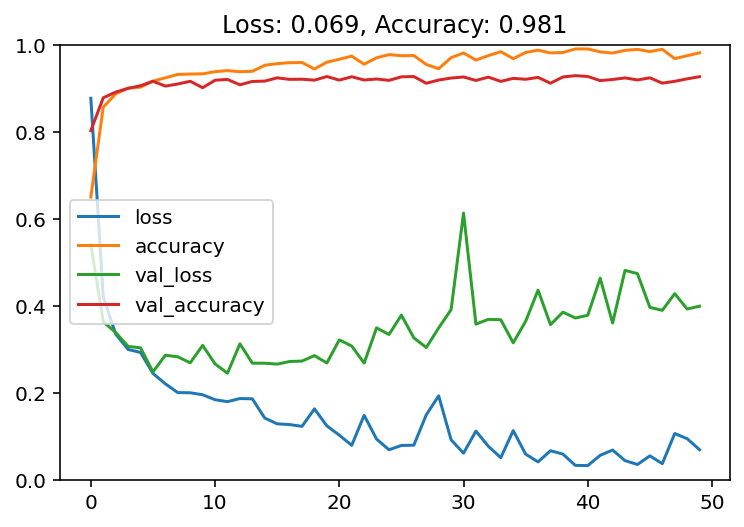

In [ ]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0, validation_split=.1)   
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

The performance of model10 VGG-16 reaches 0.921, second best of all, just a bit poorer than best model9. \\
But it's worth to notice that VGG-16 has a number of parameters 33,637,066, which is way larger than the number of parameters of best model9 1,637,570. \\